# Vendor Recommender - EDA
@olibolly

# Open TO-DO
- ** Link the notebook with github using ungit - DONE**
- ** Provide access to the project if we go for Big query - DONE **
- ** Re-pull EDA using updated 2016-2017 data**
- ** Further EDA on collaborative filtering**
- ** Run first regression to understand what features matter**
- ** Join tables FAPIIS and USA spending **

## Useful links
- https://github.com/antontarasenko/gpq

## Dataset


 - USASpending.gov available on BigQuery dataset (17 years of data, 45mn transactions, $6.7tn worth of goods and services): [gpqueries:contracts](https://bigquery.cloud.google.com/dataset/gpqueries:contracts) 
 - Past Performance Information Retrieval System (PPIRS) -> review - **not public data**
     - System for Award Management (SAM)
     - FAPIIS
     
 - **Are they any other dataset we should be considering?? **

## Table `gpqueries:contracts.raw`

Table [`gpqueries:contracts.raw`](https://bigquery.cloud.google.com/table/gpqueries:contracts.raw) contains the unmodified data from the [USASpending.gov archives](https://www.usaspending.gov/DownloadCenter/Pages/dataarchives.aspx). It's constructed from `<year>_All_Contracts_Full_20160515.csv.zip` files and includes contracts from 2000 to May 15, 2016.

Table `gpqueries:contracts.raw` contains 45M rows and 225 columns.

Each row refers to a transaction (a purchase or refund) made by a federal agency. It may be a pizza or an airplane.

The columns are grouped into categories:

- Transaction: `unique_transaction_id`-`baseandalloptionsvalue`
- Buyer (government agency): `maj_agency_cat`-`fundedbyforeignentity`
- Dates: `signeddate`-`lastdatetoorder`, `last_modified_date`
- Contract: `contractactiontype`-`programacronym`
- Contractor (supplier, vendor): `vendorname`-`statecode`
- Place of performance: `PlaceofPerformanceCity`-`placeofperformancecongressionaldistrict`
- Product or service bought: `psc_cat`-`manufacturingorganizationtype`
- General contract information: `agencyid`-`idvmodificationnumber`
- Competitive procedure: `solicitationid`-`statutoryexceptiontofairopportunity`
- Contractor details: `organizationaltype`-`otherstatutoryauthority`
- Contractor's executives: `prime_awardee_executive1`-`interagencycontractingauthority`

Detailed description for each variable is available in the official codebook:

- [`USAspending.govDownloadsDataDictionary.pdf`](https://www.usaspending.gov/DownloadCenter/Documents/USAspending.govDownloadsDataDictionary.pdf)

In [63]:
import google.datalab.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## SAM (System for Award Management) - exclusions

- https://www.sam.gov/sam/transcript/SAM_Exclusions_Public_Extract_Layout.pdf

In [2]:
%%sql
select * from [fiery-set-171213:vrec.sam_exclusions] limit 5

Classification,Name,Prefix,First,Middle,Last,Suffix,Address_1,Address_2,Address_3,Address_4,City,State___Province,Country,Zip_Code,DUNS,Exclusion_Program,Excluding_Agency,CT_Code,Exclusion_Type,Additional_Comments,Active_Date,Termination_Date,Record_Status,Cross_Reference,SAM_Number,CAGE,NPI
,,,DAMASO,,LOPEZ NUNEZ,,,,,,"CULIACAN, SINALOA",,MEX,80450,,,,,,,,,,,S4MR47FDZ,,
,,,ZAKHARY KNYAZEVICH,,KALASHOV,,,,,,TBILISI,,GEO,,,,,,,,,,,,S4MR479RJ,,
,,,FILEMON,,GARCIA AYALA,,,,,,"MATAMOROS, TAMAULIPAS",,MEX,,,,,,,,,,,,S4MR47VPQ,,
,,,MUSA,,KALIM,,,,,,QUETTA,,PAK,,,,,,,,,,,,S4MR473KX,,
,LOS RASTROJOS,,,,,,,,,,,,ECU,,,,,,,,,,,,S4MR47QK3,,


In [4]:
%%sql
select Exclusion_Type from [fiery-set-171213:vrec.sam_exclusions] group by 1;

Exclusion_Type
""
Ineligible (Proceedings Completed)
Voluntary Exclusion
Ineligible (Proceedings Pending)
Prohibition/Restriction


In [5]:
%%sql
select Classification from [fiery-set-171213:vrec.sam_exclusions] group by 1;

Classification
""
Individual
Special Entity Designation
Firm
Vessel


In [6]:
%%sql
select
count(*)
from [fiery-set-171213:vrec.sam_exclusions] 
where Classification in ('Firm')
;

f0_
8659


**There are 8,659 firms on the SAM exclusion list**

In [7]:
%%bq query -n df_query
select
EXTRACT(YEAR FROM Active_Date) as year,
count(*) as count
from `fiery-set-171213.vrec.sam_exclusions`
where Classification in ('Firm')
and Active_Date is not NULL
group by 1
order by 1;

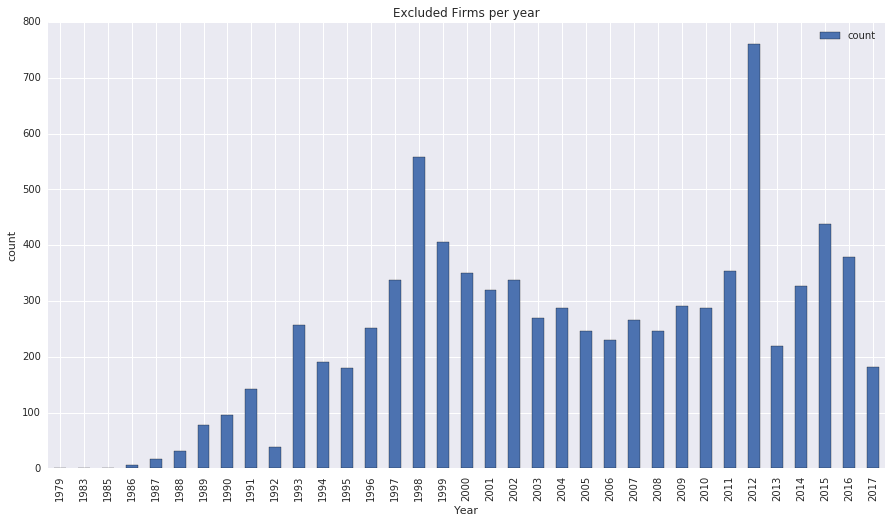

In [8]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()

ax = df.plot(kind='bar', x='year', title='Excluded Firms per year', figsize=(15,8))
ax.set_xlabel('Year')
ax.set_ylabel('count')

In [9]:
%%bq query
select
#Name,
SAM_Number,
count(*) as count
from `fiery-set-171213.vrec.sam_exclusions`
where Classification in ('Firm')
#and Active_Date is not NULL
group by 1
order by 2 DESC
limit 5;

SAM_Number,count
S4MR4D26H,6
S4MR1SHZ2,4
S4MR3MGDX,3
S4MR3MKV5,3
S4MR3MQNF,3


In [10]:
%%bq query
select
NPI,
count(*) as count
from `fiery-set-171213.vrec.sam_exclusions`
where Classification in ('Firm')
#and CAGE is not NULL
group by 1
order by 2 DESC
limit 5;

NPI,count
,8496
0,7
1215968847,4
1437333259,4
1083746069,3


In [11]:
%%bq query
select
CAGE,
count(*) as count
from `fiery-set-171213.vrec.sam_exclusions`
where Classification in ('Firm')
#and CAGE is not NULL
group by 1
order by 2 DESC
limit 5;

CAGE,count
,8102
0TEF4,4
4LD15,4
1YEC5,4
5S6L2,4


** NPI and CAGE don't seem to be great keys to join the data - ideally we can use SAM ** 

## Federal Awardee Performance and Integrity Information System (FAPIIS)
- This is the contractor's fault - you can do business with these contractors on SAM one cannot do business with
- Only 5 years by design

In [12]:
%%bq query
select * 
from `fiery-set-171213.vrec.fapiis` 
limit 5

AGENCY,RECORD_TYPE,RECORD_DATE,CONTRACT_GRANT_NUMBER,REFERENCED_NUMBER,SOLICITATION_FUNDING_NUMBER,DUNS,CAGE,AWARDEE_NAME,ADDRESS1,ADDRESS2,CITY,STATE,ZIP_CODE,COUNTRY,VIOLATION_AGAINST,SUBCONTRACTOR_DUNS,SUBCONTRACTOR_CAGE,SUBCONTRACTOR_NAME,SUBCONTRACTOR_ADDRESS1,SUBCONTRACTOR_ADDRESS2,SUBCONTRACTOR_CITY,SUBCONTRACTOR_STATE,SUBCONTRACTOR_ZIP_CODE,SUBCONTRACTOR_COUNTRY,FSC,NAICS,AGENCY_CODE,CODE_2,OFFICIAL_NAME,OFFICIAL_PHONE,OFFICIAL_EMAIL,TERMINATION_TYPE,TERMINATION_DATE,USER,EMAIL,PHONE,COMMENTS
"STATE, DEPARTMENT OF",Termination for Material Failure to Comply,2016-06-29,SWA80014GR035,,,539146515,,LUDWIG NDINDA PRIMARY PLAYGROUND PROJECT,P.O. BOX 15,,OKAKARARA,,,NAM,,,,,,,,,,,,,,1900,KRISTEN ERTHUM,202-647-7915,erthumk@state.gov,N/A,,,,,
DEPT OF THE NAVY,DoD Determination of Contractor Fault,2014-01-21,M6261313P0177,,,12820064,,NASSAU CABLE CORP,150 GREAT NECK RD STE 305,,GREAT NECK,NY,11021,US,,,,,,,,,,,,5895,331420,1700,KIM SAKURA HIGA,81989702577,sakura.higa@usmc.mil,N/A,,,,,
"STATE, DEPARTMENT OF",Termination for Material Failure to Comply,2016-02-08,SCE20012GR094,,,659427269,,ORGANIZATION FOR HABITATION AND RESOURCES DEVELOPMENT,"258, 18, RAILWAY STATION ROAD, THILLAYADI",,PUTTALAM,,,LKA,,,,,,,,,,,,,,1900,ELIADAH COE,202-647-9544,coeem@state.gov,N/A,,,,,
"INTERIOR, DEPARTMENT OF THE",Subcontractor Payment Issues,2015-11-05,INR15PX00625,,,44271201,,D T M ASSOCIATES LIMITED LIABILITY COMPANY,1200 PENNSYLVANIA AVE,,MCDONOUGH,GA,302538999,USA,,,,,,,,,,,,3750,333112,1400,LYNETTE ROCK,801-524-3798,lrock@usbr.gov,N/A,,,,,
DEPT OF THE NAVY,DoD Determination of Contractor Fault,2017-01-09,N6883616P1114,,,79862858,7E6E6,OBELLO INC,7604 E 117TH TER,,KANSAS CITY,MO,641343925,USA,,,,,,,,,,,,D399,517919,1700,DAVID DIAZ,912-573-2656,david.diaz1@navy.mil,N/A,,,,,


In [13]:
%%bq query -n df_query
select
EXTRACT(YEAR FROM RECORD_DATE) as year,
count(*) as count
from `fiery-set-171213.vrec.fapiis`
group by 1
order by 1;

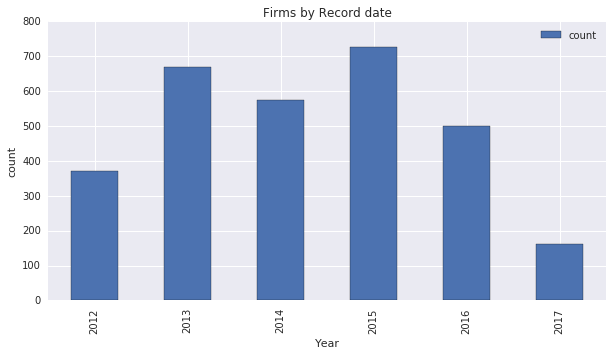

In [14]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()

ax = df.plot(kind='bar', x='year', title='Firms by Record date', figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('count')

In [15]:
%%bq query -n df_query
select
EXTRACT(YEAR FROM TERMINATION_DATE) as year,
count(*) as count
from `fiery-set-171213.vrec.fapiis`
group by 1
order by 1;

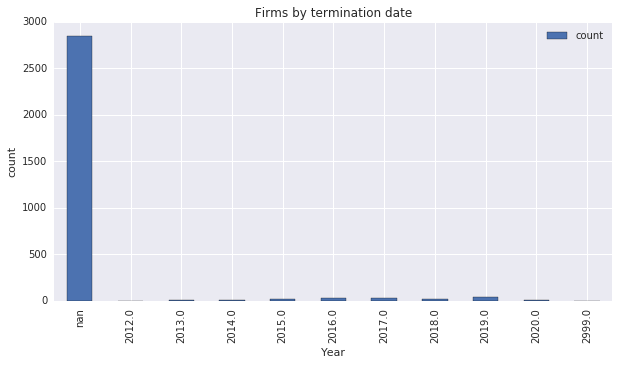

In [16]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()

ax = df.plot(kind='bar', x='year', title='Firms by termination date', figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('count')

In [17]:
%%bq query
select
AWARDEE_NAME,
DUNS,
count(*) as count
from `fiery-set-171213.vrec.fapiis`
group by 1,2
order by 3 DESC
limit 5;

AWARDEE_NAME,DUNS,count
ALPHA RAPID ENGINEERING SOLUTIONS,968818497,96
SDV RECON INC,828479498,72
"GIESTING & ASSOCIATES, INC.",68939842,41
"UNITED PROCUREMENT, L.P.",628036345,31
"EPITECH, INC.",190378625,31


In [18]:
%%bq query
select
*
from `fiery-set-171213.vrec.fapiis`
where AWARDEE_NAME in ('ALPHA RAPID ENGINEERING SOLUTIONS')
limit 5;

AGENCY,RECORD_TYPE,RECORD_DATE,CONTRACT_GRANT_NUMBER,REFERENCED_NUMBER,SOLICITATION_FUNDING_NUMBER,DUNS,CAGE,AWARDEE_NAME,ADDRESS1,ADDRESS2,CITY,STATE,ZIP_CODE,COUNTRY,VIOLATION_AGAINST,SUBCONTRACTOR_DUNS,SUBCONTRACTOR_CAGE,SUBCONTRACTOR_NAME,SUBCONTRACTOR_ADDRESS1,SUBCONTRACTOR_ADDRESS2,SUBCONTRACTOR_CITY,SUBCONTRACTOR_STATE,SUBCONTRACTOR_ZIP_CODE,SUBCONTRACTOR_COUNTRY,FSC,NAICS,AGENCY_CODE,CODE_2,OFFICIAL_NAME,OFFICIAL_PHONE,OFFICIAL_EMAIL,TERMINATION_TYPE,TERMINATION_DATE,USER,EMAIL,PHONE,COMMENTS
DEFENSE COMMISSARY AGENCY (DECA),Termination for Cause,2015-09-04,HDEC0413D00170257,,,968818497,6GLG3,ALPHA RAPID ENGINEERING SOLUTIONS,3159 SHRADER RD,,DOVER,NJ,7801,USA,,,,,,,,,,,,7420,333318,97AZ,DESSIE MILLS,8047348000,dessie.mills@deca.mil,Complete,,,,,
DEFENSE COMMISSARY AGENCY (DECA),Termination for Cause,2015-09-04,HDEC0413D00170259,,,968818497,6GLG3,ALPHA RAPID ENGINEERING SOLUTIONS,3159 SHRADER RD,,DOVER,NJ,7801,USA,,,,,,,,,,,,7420,333318,97AZ,DESSIE MILLS,8047348000,dessie.mills@deca.mil,Complete,,,,,
DEFENSE COMMISSARY AGENCY (DECA),Termination for Cause,2015-09-04,HDEC0413D00170260,,,968818497,6GLG3,ALPHA RAPID ENGINEERING SOLUTIONS,3159 SHRADER RD,,DOVER,NJ,7801,USA,,,,,,,,,,,,7420,333318,97AZ,DESSIE MILLS,8047348000,dessie.mills@deca.mil,Complete,,,,,
DEFENSE COMMISSARY AGENCY (DECA),Termination for Cause,2015-09-02,268,HDEC0413D0017,,968818497,6GLG3,ALPHA RAPID ENGINEERING SOLUTIONS,3159 SHRADER RD,,DOVER,NJ,78015735,USA,,,,,,,,,,,,7420,333318,97AZ,DESSIE MILLS,8047348000,dessie.mills@deca.mil,Complete,,,,,
DEFENSE COMMISSARY AGENCY (DECA),Termination for Cause,2015-09-04,HDEC0413D00170258,,,968818497,6GLG3,ALPHA RAPID ENGINEERING SOLUTIONS,3159 SHRADER RD,,DOVER,NJ,7801,USA,,,,,,,,,,,,7420,333318,97AZ,DESSIE MILLS,8047348000,dessie.mills@deca.mil,Complete,,,,,


In [19]:
%%bq query
select
RECORD_TYPE,
count(*) as count
from `fiery-set-171213.vrec.fapiis`
group by 1
order by 2 DESC

RECORD_TYPE,count
Termination for Cause,1603
Termination for Default,1182
Administrative Agreement,158
Non-Responsibility Determination,48
Termination for Material Failure to Comply,8
DoD Determination of Contractor Fault,2
Subcontractor Payment Issues,1


**FAPIIS is not bad with 3002 DUNS code but time range goes only from 2012 to 2017**

## USA Spending

- Link to collaborative filtering
- https://docs.google.com/presentation/d/1x5g-wIoSUGRSwDqHC6MhZBZD5d2LQ19WKFlRneN2TyU/edit#slide=id.p121

- https://www.usaspending.gov/DownloadCenter/Documents/USAspending.govDownloadsDataDictionary.pdf

In [3]:
%%bq query -n df_query
select count(*) as transactions
from `fiery-set-171213.vrec.usa_spending_all`

In [4]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head()

,transactions
0,49454646


In [22]:
%%bq query
select *
from `fiery-set-171213.vrec.usa_spending_all`
where mod_agency in ('1700: DEPT OF THE NAVY')
limit 5

unique_transaction_id,transaction_status,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,maj_agency_cat,mod_agency,maj_fund_agency_cat,contractingofficeagencyid,contractingofficeid,fundingrequestingagencyid,fundingrequestingofficeid,fundedbyforeignentity,signeddate,effectivedate,currentcompletiondate,ultimatecompletiondate,lastdatetoorder,contractactiontype,reasonformodification,typeofcontractpricing,priceevaluationpercentdifference,subcontractplan,lettercontract,multiyearcontract,performancebasedservicecontract,majorprogramcode,contingencyhumanitarianpeacekeepingoperation,contractfinancing,costorpricingdata,costaccountingstandardsclause,descriptionofcontractrequirement,purchasecardaspaymentmethod,numberofactions,nationalinterestactioncode,progsourceagency,progsourceaccount,progsourcesubacct,account_title,rec_flag,typeofidc,multipleorsingleawardidc,programacronym,vendorname,vendoralternatename,vendorlegalorganizationname,vendordoingasbusinessname,divisionname,divisionnumberorofficecode,vendorenabled,vendorlocationdisableflag,ccrexception,streetaddress,streetaddress2,streetaddress3,city,state,zipcode,vendorcountrycode,vendor_state_code,vendor_cd,congressionaldistrict,vendorsitecode,vendoralternatesitecode,dunsnumber,parentdunsnumber,phoneno,faxno,registrationdate,renewaldate,mod_parent,locationcode,statecode,PlaceofPerformanceCity,pop_state_code,placeofperformancecountrycode,placeofperformancezipcode,pop_cd,placeofperformancecongressionaldistrict,psc_cat,productorservicecode,systemequipmentcode,claimantprogramcode,principalnaicscode,informationtechnologycommercialitemcategory,gfe_gfp,useofepadesignatedproducts,recoveredmaterialclauses,seatransportation,contractbundling,consolidatedcontract,countryoforigin,placeofmanufacture,manufacturingorganizationtype,agencyid,piid,modnumber,transactionnumber,fiscal_year,idvagencyid,idvpiid,idvmodificationnumber,solicitationid,extentcompeted,reasonnotcompeted,numberofoffersreceived,commercialitemacquisitionprocedures,commercialitemtestprogram,smallbusinesscompetitivenessdemonstrationprogram,a76action,competitiveprocedures,solicitationprocedures,typeofsetaside,localareasetaside,evaluatedpreference,fedbizopps,research,statutoryexceptiontofairopportunity,organizationaltype,numberofemployees,annualrevenue,firm8aflag,hubzoneflag,sdbflag,issbacertifiedsmalldisadvantagedbusiness,shelteredworkshopflag,hbcuflag,educationalinstitutionflag,womenownedflag,veteranownedflag,srdvobflag,localgovernmentflag,minorityinstitutionflag,aiobflag,stategovernmentflag,federalgovernmentflag,minorityownedbusinessflag,apaobflag,tribalgovernmentflag,baobflag,naobflag,saaobflag,nonprofitorganizationflag,isothernotforprofitorganization,isforprofitorganization,isfoundation,haobflag,ishispanicservicinginstitution,emergingsmallbusinessflag,hospitalflag,contractingofficerbusinesssizedetermination,is1862landgrantcollege,is1890landgrantcollege,is1994landgrantcollege,isveterinarycollege,isveterinaryhospital,isprivateuniversityorcollege,isschoolofforestry,isstatecontrolledinstitutionofhigherlearning,isserviceprovider,receivescontracts,receivesgrants,receivescontractsandgrants,isairportauthority,iscouncilofgovernments,ishousingauthoritiespublicortribal,isinterstateentity,isplanningcommission,isportauthority,istransitauthority,issubchapterscorporation,islimitedliabilitycorporation,isforeignownedandlocated,isarchitectureandengineering,isdotcertifieddisadvantagedbusinessenterprise,iscitylocalgovernment,iscommunitydevelopedcorporationownedfirm,iscommunitydevelopmentcorporation,isconstructionfirm,ismanufacturerofgoods,iscorporateentitynottaxexempt,iscountylocalgovernment,isdomesticshelter,isfederalgovernmentagency,isfederallyfundedresearchanddevelopmentcorp,isforeigngovernment,isindiantribe,isintermunicipallocalgovernment,isinternationalorganization,islaborsurplusareafirm,islocalgovernmentowned,ismunicipalitylocalgovernment,isnativehawaiianownedorganizationorfirm,isotherbusinessororganization,isotherminorityowned,isp

In [23]:
%%bq query -n df_query
select
#substr(signeddate, 1, 2) month,
fiscal_year as year,  
count(*) transactions,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
group by year
order by year asc

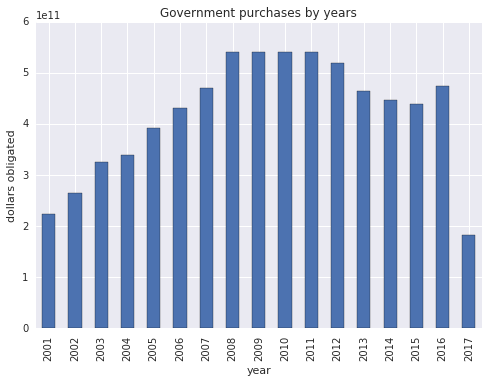

In [24]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
ax = df.set_index('year')['dollarsobligated'].plot(kind='bar', title='Government purchases by years')
ax.set_ylabel('dollars obligated')

In [25]:
%%bq query -n df_query
select
fiscal_year as year,  
sum(dollarsobligated)/count(*) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
group by year
order by year asc

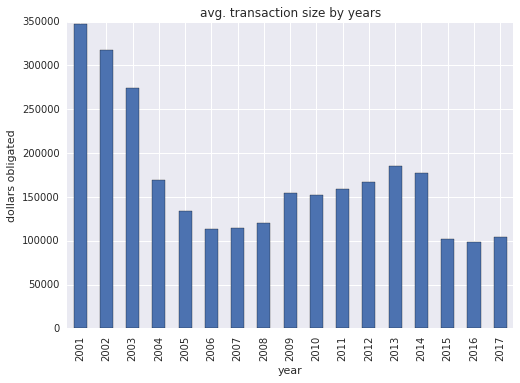

In [26]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
ax = df.set_index('year')['dollarsobligated'].plot(kind='bar', title='avg. transaction size by years')
ax.set_ylabel('dollars obligated')

** Which means we're dealing with 49.5M transactions totalling 6.7 trillion dollars. These purchases came from 622k vendors that won 2.2mn solicitations issued by government agencies.**

In [27]:
%%bq query 
select
maj_agency_cat,
mod_agency,
count(*)
from `fiery-set-171213.vrec.usa_spending_all`
group by 1,2
order by 3 DESC
limit 20

maj_agency_cat,mod_agency,f0_
9700: DEPT OF DEFENSE,97AS: DEFENSE LOGISTICS AGENCY,5829407
4700: GENERAL SERVICES ADMINISTRATION,4730: FEDERAL ACQUISITION SERVICE,5001861
"3600: VETERANS AFFAIRS, DEPARTMENT OF","3600: VETERANS AFFAIRS, DEPARTMENT OF",4956277
9700: DEPT OF DEFENSE,2100: DEPT OF THE ARMY,4338326
9700: Department of Defense,,3663469
9700: DEPT OF DEFENSE,1700: DEPT OF THE NAVY,3561991
9700: Department of Defense,97AS: DEFENSE LOGISTICS AGENCY,3470140
9700: DEPT OF DEFENSE,5700: DEPT OF THE AIR FORCE,1701478
4700: GENERAL SERVICES ADMINISTRATION,4732: FEDERAL ACQUISITION SERVICE,1444491
4700: GENERAL SERVICES ADMINISTRATION,4740: PUBLIC BUILDINGS SERVICE,1436683


In [28]:
%%bq query
select
mod_parent,
vendorname,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
group by 1,2
order by 3 DESC
limit 20

mod_parent,vendorname,dollarsobligated
LOCKHEED MARTIN CORPORATION,LOCKHEED MARTIN CORPORATION,4.06140595405e+11
RAYTHEON COMPANY,RAYTHEON COMPANY,1.43185541382e+11
THE BOEING COMPANY,THE BOEING COMPANY,81604985662.4
THE BOEING COMPANY,MCDONNELL DOUGLAS CORPORATION,80799250038.5
GENERAL DYNAMICS CORPORATION,ELECTRIC BOAT CORPORATION,59956826888.2
THE BOEING COMPANY,"BOEING COMPANY, THE",58976360811.5
MCKESSON CORPORATION,MCKESSON CORPORATION,51476224729.7
MISCELLANEOUS FOREIGN CONTRACTORS,MISCELLANEOUS FOREIGN CONTRACTORS,45689431658.1
NORTHROP GRUMMAN CORPORATION,NORTHROP GRUMMAN SYSTEMS CORPORATION,43705606171.4
UNITED TECHNOLOGIES CORPORATION,SIKORSKY AIRCRAFT CORPORATION,42109220881.9


### Understanding where the budget is spent

In [29]:
%%bq query
select
productorservicecode,
systemequipmentcode,
claimantprogramcode,
principalnaicscode,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where vendorname in ('LOCKHEED MARTIN CORPORATION')
group by 1,2,3,4
order by 5 DESC
limit 20

productorservicecode,systemequipmentcode,claimantprogramcode,principalnaicscode,dollarsobligated
"1510: AIRCRAFT, FIXED WING",198: JSF (F-35),A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,28184206750.3
AC15: DEFENSE AIRCRAFT (OPERATIONAL),:,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,26151446019.5
"1510: AIRCRAFT, FIXED WING",:,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,19916460350.7
"1510: AIRCRAFT, FIXED WING",265: F/A-22,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,15905680755.8
"1510: AIRCRAFT, FIXED WING",198: F-35,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,14576942151.1
"1510: AIRCRAFT, FIXED WING",220: C130-J,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,9329833845.35
AR92: R&D-OTHER SPACE-A RES/EXPL DEV,:,A2: MISSILE AND SPACE SYSTEMS,"541710: RESEARCH AND DEVELOPMENT IN THE PHYSICAL, ENGINEERING, AND LIFE SCIENCES",7604013454.81
"1510: AIRCRAFT, FIXED WING",198: F-35,A1A: AIRFRAMES AND SPARES,336411,6729682365.63
AC15: R&D- DEFENSE SYSTEM: AIRCRAFT (OPERATIONAL SYSTEMS DEVELOPMENT),:,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,6320634728.51
1420: GUIDED MISSILE COMPONENTS,178: TRIDENT II MISSILE,A2: MISSILE AND SPACE SYSTEMS,336414: GUIDED MISSILE AND SPACE VEHICLE MANUFACTURING,6302806071.0


In [30]:
%%bq query
select
#mod_parent,
vendorname,
systemequipmentcode,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where productorservicecode in ('1510: AIRCRAFT, FIXED WING')
group by 1,2
order by 3 DESC
limit 20

vendorname,systemequipmentcode,dollarsobligated
LOCKHEED MARTIN CORPORATION,198: JSF (F-35),28184206750.3
LOCKHEED MARTIN CORPORATION,:,26614890662.8
MCDONNELL DOUGLAS CORPORATION,200: C-17A,22087470030.8
LOCKHEED MARTIN CORPORATION,198: F-35,21306624516.7
LOCKHEED MARTIN CORPORATION,265: F/A-22,19154681175.1
MCDONNELL DOUGLAS CORPORATION,549: F/A-18 E/F,18911200956.0
THE BOEING COMPANY,:,13936870961.3
THE BOEING COMPANY,334: P-8A,11100547106.4
"BOEING COMPANY, THE",:,10720289251.5
MCDONNELL DOUGLAS CORPORATION,:,10702937261.0


In [32]:
%%bq query
select
vendorname,
systemequipmentcode,
claimantprogramcode,
principalnaicscode,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where productorservicecode in ('1510: AIRCRAFT, FIXED WING')
and contractingofficerbusinesssizedetermination in ('S: SMALL BUSINESS')
group by 1,2,3,4
order by dollarsobligated DESC
limit 20

vendorname,systemequipmentcode,claimantprogramcode,principalnaicscode,dollarsobligated
SABRELINER CORPORATION,3ADH:,A1A: AIRFRAMES AND SPARES,336413: OTHER AIRCRAFT PARTS AND AUXILIARY EQUIPMENT MANUFACTURING,115828265.0
TKC AEROSPACE,:,:,541330: ENGINEERING SERVICES,57520022.28
MISSION RESEARCH CORPORATION,:,A1A: AIRFRAMES AND SPARES,336413: OTHER AIRCRAFT PARTS AND AUXILIARY EQUIPMENT MANUFACTURING,53402855.9
"ORION AIR GROUP, LLC",:,A1C: OTHER AIRCRAFT EQUIPMENT,336411: AIRCRAFT MANUFACTURING,50000000.0
AEROVIRONMENT INCORPORATED,:,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,44710062.38
"DYNAMIC AVIATION GROUP, INC.",:,A1A: AIRFRAMES AND SPARES,336411: AIRCRAFT MANUFACTURING,39218969.0
TKC AEROSPACE INC.,:,:,336411: AIRCRAFT MANUFACTURING,33869649.97
TKC AEROSPACE,:,:,336411: AIRCRAFT MANUFACTURING,31932233.4
"TKC AEROSPACE, INC.",:,:,336411: AIRCRAFT MANUFACTURING,31925543.76
DME CORPORATIONINC,3000:,A1C: OTHER AIRCRAFT EQUIPMENT,336411: AIRCRAFT MANUFACTURING,31710250.0


In [190]:
%%bq query
select
*
from `gpqueries.contracts.raw`
where productorservicecode in ('1510: AIRCRAFT, FIXED WING')
and contractingofficerbusinesssizedetermination in ('S: SMALL BUSINESS')
limit 1

unique_transaction_id,transaction_status,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,maj_agency_cat,mod_agency,maj_fund_agency_cat,contractingofficeagencyid,contractingofficeid,fundingrequestingagencyid,fundingrequestingofficeid,fundedbyforeignentity,signeddate,effectivedate,currentcompletiondate,ultimatecompletiondate,lastdatetoorder,contractactiontype,reasonformodification,typeofcontractpricing,priceevaluationpercentdifference,subcontractplan,lettercontract,multiyearcontract,performancebasedservicecontract,majorprogramcode,contingencyhumanitarianpeacekeepingoperation,contractfinancing,costorpricingdata,costaccountingstandardsclause,descriptionofcontractrequirement,purchasecardaspaymentmethod,numberofactions,nationalinterestactioncode,progsourceagency,progsourceaccount,progsourcesubacct,account_title,rec_flag,typeofidc,multipleorsingleawardidc,programacronym,vendorname,vendoralternatename,vendorlegalorganizationname,vendordoingasbusinessname,divisionname,divisionnumberorofficecode,vendorenabled,vendorlocationdisableflag,ccrexception,streetaddress,streetaddress2,streetaddress3,city,state,zipcode,vendorcountrycode,vendor_state_code,vendor_cd,congressionaldistrict,vendorsitecode,vendoralternatesitecode,dunsnumber,parentdunsnumber,phoneno,faxno,registrationdate,renewaldate,mod_parent,locationcode,statecode,PlaceofPerformanceCity,pop_state_code,placeofperformancecountrycode,placeofperformancezipcode,pop_cd,placeofperformancecongressionaldistrict,psc_cat,productorservicecode,systemequipmentcode,claimantprogramcode,principalnaicscode,informationtechnologycommercialitemcategory,gfe_gfp,useofepadesignatedproducts,recoveredmaterialclauses,seatransportation,contractbundling,consolidatedcontract,countryoforigin,placeofmanufacture,manufacturingorganizationtype,agencyid,piid,modnumber,transactionnumber,fiscal_year,idvagencyid,idvpiid,idvmodificationnumber,solicitationid,extentcompeted,reasonnotcompeted,numberofoffersreceived,commercialitemacquisitionprocedures,commercialitemtestprogram,smallbusinesscompetitivenessdemonstrationprogram,a76action,competitiveprocedures,solicitationprocedures,typeofsetaside,localareasetaside,evaluatedpreference,fedbizopps,research,statutoryexceptiontofairopportunity,organizationaltype,numberofemployees,annualrevenue,firm8aflag,hubzoneflag,sdbflag,issbacertifiedsmalldisadvantagedbusiness,shelteredworkshopflag,hbcuflag,educationalinstitutionflag,womenownedflag,veteranownedflag,srdvobflag,localgovernmentflag,minorityinstitutionflag,aiobflag,stategovernmentflag,federalgovernmentflag,minorityownedbusinessflag,apaobflag,tribalgovernmentflag,baobflag,naobflag,saaobflag,nonprofitorganizationflag,isothernotforprofitorganization,isforprofitorganization,isfoundation,haobflag,ishispanicservicinginstitution,emergingsmallbusinessflag,hospitalflag,contractingofficerbusinesssizedetermination,is1862landgrantcollege,is1890landgrantcollege,is1994landgrantcollege,isveterinarycollege,isveterinaryhospital,isprivateuniversityorcollege,isschoolofforestry,isstatecontrolledinstitutionofhigherlearning,isserviceprovider,receivescontracts,receivesgrants,receivescontractsandgrants,isairportauthority,iscouncilofgovernments,ishousingauthoritiespublicortribal,isinterstateentity,isplanningcommission,isportauthority,istransitauthority,issubchapterscorporation,islimitedliabilitycorporation,isforeignownedandlocated,isarchitectureandengineering,isdotcertifieddisadvantagedbusinessenterprise,iscitylocalgovernment,iscommunitydevelopedcorporationownedfirm,iscommunitydevelopmentcorporation,isconstructionfirm,ismanufacturerofgoods,iscorporateentitynottaxexempt,iscountylocalgovernment,isdomesticshelter,isfederalgovernmentagency,isfederallyfundedresearchanddevelopmentcorp,isforeigngovernment,isindiantribe,isintermunicipallocalgovernment,isinternationalorganization,islaborsurplusareafirm,islocalgovernmentowned,ismunicipalitylocalgovernment,isnativehawaiianownedorganizationorfirm,isotherbusinessororganization,isotherminorityowned,isp

In [33]:
%%bq query
select 
claimantprogramcode,
principalnaicscode,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
group by 1,2
order by dollarsobligated DESC
limit 10

claimantprogramcode,principalnaicscode,dollarsobligated
C2: CONSTRUCTION,236220: COMMERCIAL AND INSTITUTIONAL BUILDING CONSTRUCTION,60403437335.8
:,541519: OTHER COMPUTER RELATED SERVICES,43206577283.3
S1: SERVICES,541330: ENGINEERING SERVICES,42325981781.3
:,236220: COMMERCIAL AND INSTITUTIONAL BUILDING CONSTRUCTION,30723658597.9
:,541512: COMPUTER SYSTEMS DESIGN SERVICES,23153068951.3
:,541611: ADMINISTRATIVE MANAGEMENT AND GENERAL MANAGEMENT CONSULTING SERVICES,23053212686.1
S1: SERVICES,561210: FACILITIES SUPPORT SERVICES,22290451538.3
:,541511: CUSTOM COMPUTER PROGRAMMING SERVICES,18313101434.9
C2: CONSTRUCTION,237990: OTHER HEAVY AND CIVIL ENGINEERING CONSTRUCTION,17921409986.7
:,:,17431988986.3


### Looking at SMBs by year


In [34]:
%%bq query -n df_query
select 
fiscal_year,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
group by 1
order by 1

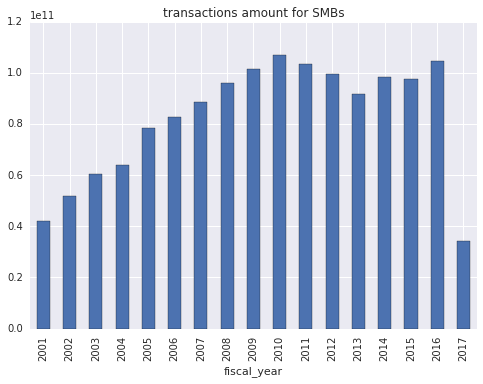

In [35]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
plt = df.set_index('fiscal_year')['dollarsobligated'].plot(kind='bar', title='transactions amount for SMBs')

In [36]:
%%bq query -n df_query
#%%sql
select 
smb.fiscal_year,
sum(smb.transaction) as smb,
sum(total.transaction) as total,
sum(smb.transaction)/sum(total.transaction) as percentage
from
(select 
  fiscal_year,
  sum(dollarsobligated) as transaction
  from `fiery-set-171213.vrec.usa_spending_all`
  where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
  group by 1) as smb
join 
(select
  fiscal_year,
  sum(dollarsobligated) as transaction
  from `fiery-set-171213.vrec.usa_spending_all`
  group by 1) as total
on smb.fiscal_year = total.fiscal_year
group by 1
order by 1

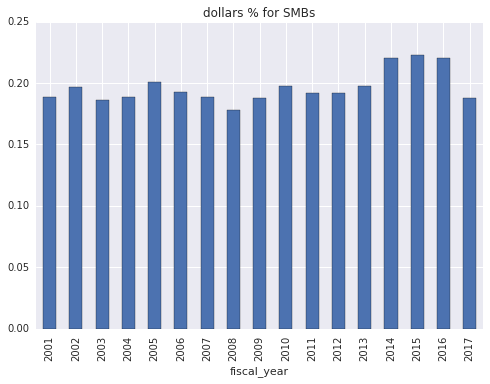

In [37]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
plt = df.set_index('fiscal_year')['percentage'].plot(kind='bar', title='dollars % for SMBs')

### SMB contract by gov. agency & by naics code

In [38]:
%%bq query
select 
smb.principalnaicscode as principalnaicscode,
sum(total.count) as count,
sum(smb.dollarsobligated) as dollarsobligated_smb,
sum(total.dollarsobligated) as dollarsobligated_total,
sum(smb.dollarsobligated)/sum(total.dollarsobligated) as smb_percentage
from
(select 
  principalnaicscode,
  count(*) as count,
  sum(dollarsobligated) as dollarsobligated
  from `fiery-set-171213.vrec.usa_spending_all`
  where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
  group by 1) as smb
join 
(select
  principalnaicscode,
  count(*) as count,
  sum(dollarsobligated) as dollarsobligated
  from `fiery-set-171213.vrec.usa_spending_all`
  group by 1
  having dollarsobligated > 0
) as total
on smb.principalnaicscode = total.principalnaicscode
group by 1
order by 5 DESC
limit 10

principalnaicscode,count,dollarsobligated_smb,dollarsobligated_total,smb_percentage
111334: BERRY (EXCEPT STRAWBERRY) FARMING,49,83928.0,7277.13,11.5331181386
518111,430,8270781.4,1150208.47,7.19068031207
323115,57,95535.42,14640.23,6.52554092388
421210,8,57041.91,33780.44,1.68860766763
531311,379,16838508.16,11813329.96,1.42538202328
337125,231,719004.07,551770.31,1.30308582569
331411: PRIMARY SMELTING AND REFINING OF COPPER,298,30042581.88,23504524.94,1.27816162874
333412,101,1009259.61,830330.81,1.21549098003
333411,435,13352294.76,12155472.22,1.0984595677
112320,17,106395.1,99085.5,1.07377063243


## Simple Linear regression (LR)

### LR: predict the size of the contract

- A lot of categorical feature -> needs to binarize it -> creates very sparse Matrix -> poor performance for LR
- R square of to 2%
- Not ideal for the problem we are trying for here

In [176]:
%%bq query -n df_query
select
maj_agency_cat,
#mod_agency,
#contractactiontype,
#typeofcontractpricing,
#performancebasedservicecontract,
state,
#vendorcountrycode,
#principalnaicscode,
contractingofficerbusinesssizedetermination,
#sum(dollarsobligated) as dollarsobligated
dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where vendorcountrycode in ('UNITED STATES', 'USA: UNITED STATES OF AMERICA')
and contractingofficerbusinesssizedetermination in ('O: OTHER THAN SMALL BUSINESS', 'S: SMALL BUSINESS')
and dollarsobligated > 0
#group by 1,2,3
limit 20000

In [177]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head()

,maj_agency_cat,state,contractingofficerbusinesssizedetermination,dollarsobligated
0,"3600: VETERANS AFFAIRS, DEPARTMENT OF",AL,S: SMALL BUSINESS,2971.20
1,"3600: VETERANS AFFAIRS, DEPARTMENT OF",AL,S: SMALL BUSINESS,700000.00
2,"1400: INTERIOR, DEPARTMENT OF THE",AR,S: SMALL BUSINESS,35549.00
3,4700: GENERAL SERVICES ADMINISTRATION,AZ,S: SMALL BUSINESS,43.72
4,"3600: VETERANS AFFAIRS, DEPARTMENT OF",AZ,S: SMALL BUSINESS,40504.63


In [178]:
# Create dummy variable using pandas function get_dummies
df1 = df.join(pd.get_dummies(df['maj_agency_cat']))
df1 = df1.join(pd.get_dummies(df['state']))
df1 = df1.join(pd.get_dummies(df['contractingofficerbusinesssizedetermination']))

df1 = df1.drop('maj_agency_cat', axis = 1)
df1 = df1.drop('state', axis = 1)
df1 = df1.drop('contractingofficerbusinesssizedetermination', axis = 1)
df1.head()

,dollarsobligated,1100: EXECUTIVE OFFICE OF THE PRESIDENT,1145: PEACE CORPS,1153: UNITED STATES TRADE AND DEVELOPMENT AGENCY,"1200: AGRICULTURE, DEPARTMENT OF","1300: COMMERCE, DEPARTMENT OF",1300: Department of Commerce,1400: Department of the Interior,"1400: INTERIOR, DEPARTMENT OF THE",1500: Department of Justice,...,VI,VT,WA,WI,WV,WY,hi,ma,O: OTHER THAN SMALL BUSINESS,S: SMALL BUSINESS
0,2971.20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,700000.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,35549.00,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,43.72,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,40504.63,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [179]:
train_data = df1.iloc[:,1:]
train_labels = df[['dollarsobligated']]

lm = LinearRegression()
lm.fit(train_data, train_labels)

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lm.predict(train_data) - train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(train_data, train_labels))

('Coefficients: \n', array([[  6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.98552231e+17,
          6.98552231e+17,   6.98552231e+17,   6.9

### LR: Predict the number of contracts (popularity)

- Same issue than previously
- R square of to 1%
- Not ideal for the problem we are trying for here

In [182]:
%%bq query -n df_query
select
vendorname,
maj_agency_cat,
state,
contractingofficerbusinesssizedetermination,
count(*) as count,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
where vendorcountrycode in ('UNITED STATES', 'USA: UNITED STATES OF AMERICA')
and contractingofficerbusinesssizedetermination in ('O: OTHER THAN SMALL BUSINESS', 'S: SMALL BUSINESS')
and dollarsobligated > 0
group by 1,2,3,4
limit 20000

In [183]:
df = df_query.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head()

,vendorname,maj_agency_cat,state,contractingofficerbusinesssizedetermination,count,dollarsobligated
0,THE HEAT CENTER,"1500: JUSTICE, DEPARTMENT OF",,S: SMALL BUSINESS,1,1181.00
1,NEW HORIZONS TELECOM INC,"6900: TRANSPORTATION, DEPARTMENT OF",AK,S: SMALL BUSINESS,10,1017093.00
2,D AND L WOODWORKS,"1400: INTERIOR, DEPARTMENT OF THE",AK,S: SMALL BUSINESS,1,34520.00
3,"BRISTOL CONSTRUCTION SERVICES,",9700: DEPT OF DEFENSE,AK,S: SMALL BUSINESS,46,23886665.50
4,"GRANT AVIATION, INC.","1400: INTERIOR, DEPARTMENT OF THE",AK,S: SMALL BUSINESS,2,14857.08


In [185]:
#Create dummy variable using pandas function get_dummies
df1 = df.join(pd.get_dummies(df['maj_agency_cat']))
df1 = df1.join(pd.get_dummies(df['state']))
df1 = df1.join(pd.get_dummies(df['contractingofficerbusinesssizedetermination']))

df1 = df1.drop('maj_agency_cat', axis = 1)
df1 = df1.drop('state', axis = 1)
df1 = df1.drop('contractingofficerbusinesssizedetermination', axis = 1)
df1 = df1.drop('vendorname', axis = 1)
df1 = df1.drop('dollarsobligated', axis = 1)

train_data = df1.iloc[:,1:]
train_labels = df[['count']]

lm = LinearRegression()
lm.fit(train_data, train_labels)

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lm.predict(train_data) - train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(train_data, train_labels))

('Coefficients: \n', array([[  1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101469e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101469e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101470e+10,   1.40101470e+10,   1.40101470e+10,
          1.40101471e+10,   1.40101470e+10,   1.4

## Collaborative filtering

- Looking at match between gov agency & vendors
- Looking at match between product & vendors
- **TO DO, TRAINING only a subset of the data, how to expand to 49M lines? -> Need to Map/Reduce**

In [54]:
%%bq query
select
vendorname,
count(*) as count_agency
from
  (select
  #maj_agency_cat,
  vendorname,
  mod_agency,
    
  from `fiery-set-171213.vrec.usa_spending_all`
  where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
  group by 1,2)
group by 1
order by 2 DESC
limit 10

vendorname,count_agency
CARAHSOFT TECHNOLOGY CORPORATION,169
STERLING COMPUTERS CORPORATION,159
IMMIXTECHNOLOGY INC,156
"FOUR POINTS TECHNOLOGY, L.L.C.",152
DLT SOLUTIONS INCORPORATED,151
"IMMIXTECHNOLOGY, INC.",151
GTSI CORPORATION,151
"EC AMERICA, INC.",137
PATRIOT TECHNOLOGIES INC,134
"EXECUTIVE INFORMATION SYSTEMS,",134


In [55]:
%%bq query
select
vendorname,
count(*) as count_service_code
from
  (select
  vendorname,
  productorservicecode
  from `fiery-set-171213.vrec.usa_spending_all`
  #where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
  group by 1,2)
group by 1
order by 2 DESC
limit 10

vendorname,count_agency
MISCELLANEOUS FOREIGN CONTRACTORS,2601
MISCELLANEOUS FOREIGN AWARDEES,2217
LOCKHEED MARTIN CORPORATION,1025
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,983
RAYTHEON COMPANY,873
MISCELLANEOUS FOREIGN CONTRACT,807
NORTHROP GRUMMAN SYSTEMS CORPORATION,773
FOREIGN CONTRACTOR (UNDISCLOSED),739
GPC CONSOLIDATED REPORTING,694
L-3 COMMUNICATIONS CORPORATION,628


In [57]:
%%bq query
select
vendorname,
productorservicecode,
count(*) as count
from `fiery-set-171213.vrec.usa_spending_all`
#where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
where vendorname in ('LOCKHEED MARTIN CORPORATION')
group by 1,2
order by count DESC

vendorname,productorservicecode,count
LOCKHEED MARTIN CORPORATION,"5340: HARDWARE, COMMERCIAL",60228
LOCKHEED MARTIN CORPORATION,2540: VEHICULAR FURNITURE AND ACCESSORIES,30066
LOCKHEED MARTIN CORPORATION,"2940: ENGINE AIR AND OIL FILTERS, STRAINERS, AND CLEANERS, NONAIRCRAFT",16583
LOCKHEED MARTIN CORPORATION,"4330: CENTRIFUGALS, SEPARATORS, AND PRESSURE AND VACUUM FILTERS",15802
LOCKHEED MARTIN CORPORATION,"2990: MISCELLANEOUS ENGINE ACCESSORIES, NONAIRCRAFT",11232
LOCKHEED MARTIN CORPORATION,"1510: AIRCRAFT, FIXED WING",8087
LOCKHEED MARTIN CORPORATION,5930: SWITCHES,7881
LOCKHEED MARTIN CORPORATION,R706: SUPPORT- MANAGEMENT: LOGISTICS SUPPORT,7795
LOCKHEED MARTIN CORPORATION,"2530: VEHICULAR BRAKE, STEERING, AXLE, WHEEL, AND TRACK COMPONENTS",7686
LOCKHEED MARTIN CORPORATION,1560: AIRFRAME STRUCTURAL COMPONENTS,6588


# MVP

## MVP 1 - The most popular vendor
- Search query = 'construction'
- Enter your department name - eg. 'agriculture'
- Ranking based on 'counts' of number of contracts that occured

- **TO-DO check the uppercase and lowercase in the REGEX**
- **Do we want to add more parameters, such as Geo, size of the contract? To be discussed**

In [65]:
%%bq query
select
#principalnaicscode,
fiscal_year,
maj_agency_cat,
#contractingofficerbusinesssizedetermination,
#vendorname,
productorservicecode,
count(*) as count,
sum(dollarsobligated) as dollarsobligated
from `fiery-set-171213.vrec.usa_spending_all`
#where contractingofficerbusinesssizedetermination in ("S: SMALL BUSINESS")
#where regexp_contains(principalnaicscode, "CONSTRUCTION")
#and regexp_contains(maj_agency_cat, "AGRICULTURE")
where regexp_contains(productorservicecode, "MEAT")
#and fiscal_year = 2016
group by 1,2,3
order by dollarsobligated DESC
limit 10

fiscal_year,maj_agency_cat,productorservicecode,count,dollarsobligated
2012,9700: DEPT OF DEFENSE,"8905: MEAT, POULTRY, AND FISH",3881,1157422202.41
2006,9700: DEPT OF DEFENSE,"8905: MEAT, POULTRY, AND FISH",8496,1085248556.57
2011,9700: DEPT OF DEFENSE,"8905: MEAT, POULTRY, AND FISH",8203,1020507916.95
2012,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",816,854972440.02
2009,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",832,847556584.56
2013,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",909,837261896.74
2011,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",719,828393329.71
2016,1200: Department of Agriculture,"8905: MEAT, POULTRY, AND FISH",544,818812458.77
2010,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",883,814609750.75
2014,"1200: AGRICULTURE, DEPARTMENT OF","8905: MEAT, POULTRY, AND FISH",518,794157517.17


## MVP 2 - Item-Item Collaborative filtering
-  If a person A likes item 1, 2, 3 and B like 2,3,4 then they have similar interests and A should like item 4 and B should like item 1.

# TODO
- **Recommendation system: using collaborative filtering**

## OTHERS - FROM TUTORIAL - Anton Tarasenko
## Data Mining Government Clients

Suppose you want to start selling to the government. While [FBO.gov](http://www.fbo.gov/) publishes government RFPs and you can apply there, government agencies often issue requests when they've already chosen the supplier. Agencies go through FBO.gov because it's a mandatory step for deals north of $25K. But winning at this stage is unlikely if an RFP is already tailored for another supplier.

Reaching warm leads in advance would increase chances of winning a government contract. The contracts data helps identify the warm leads by looking at purchases in the previous years.

There're several ways of searching through those years.

### Who Buys What You Make

The goods and services bought in each transaction are encoded in the variable `productorservicecode`. Top ten product categories according to this variable:

In [6]:
%%sql
select
  substr(productorservicecode, 1, 4) product_id,
  first(substr(productorservicecode, 7)) product_name,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
group by
  product_id
order by
  sum_dollarsobligated desc
limit 10

product_id,product_name,transactions,sum_dollarsobligated
1510,"AIRCRAFT, FIXED WING",34373,2.84778910095e+11
M181,OPER OF GOVT R&D GOCO FACILITIES,11705,2.09034830695e+11
R425,ENGINEERING AND TECHNICAL SERVICES,540128,2.01977381246e+11
D399,OTHER ADP & TELECOMMUNICATIONS SVCS,544069,1.79749708292e+11
R499,OTHER PROFESSIONAL SERVICES,821788,1.63569940538e+11
9130,LIQUID PROPELLANTS -PETROLEUM BASE,193267,1.47092818248e+11
Q201,GENERAL HEALTH CARE SERVICES,157188,1.43893967601e+11
6505,DRUGS AND BIOLOGICALS,1857244,1.40279701467e+11
R706,LOGISTICS SUPPORT SERVICES,147238,1.17202582504e+11
R408,PROGRAM MANAGEMENT/SUPPORT SERVICES,270904,89610029462.5


You can find agencies that buy products like yours. If it's "software":

In [7]:
%%sql
select
  substr(agencyid, 1, 4) agency_id,
  first(substr(agencyid, 7)) agency_name,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
where
  productorservicecode contains 'software'
group by
  agency_id
order by
  sum_dollarsobligated desc
ignore case

agency_id,agency_name,transactions,sum_dollarsobligated
9700,DEPT OF DEFENSE,245015,31756394755.4
3600,"VETERANS AFFAIRS, DEPARTMENT OF",21223,3213678011.54
2050,INTERNAL REVENUE SERVICE,13292,2625458725.97
2800,SOCIAL SECURITY ADMINISTRATION,7038,2383445352.45
4735,FEDERAL ACQUISITION SERVICE,15064,2374494872.16
7014,U.S. CUSTOMS AND BORDER PROTECTION,3456,1816831446.67
1900,"STATE, DEPARTMENT OF",14964,1395765461.73
1549,FEDERAL BUREAU OF INVESTIGATION,4673,1104923392.94
7001,OFFICE OF PROCUREMENT OPERATIONS,2604,1076395157.89
1501,"OFFICES, BOARDS AND DIVISIONS",4617,1057842936.58


### What Firms in Your Industry Sell to the Government

Another way to find customers is the variable `principalnaicscode` that encodes the industry in which the vendor does business.

The list of NAICS codes is available at [Census.gov](http://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2012), but you can do text search in the table. Let's find who bought software from distributors in 2015:

In [6]:
%%sql
select
  substr(agencyid, 1, 4) agency_id,
  first(substr(agencyid, 7)) agency_name,
  substr(principalnaicscode, 1, 6) naics_id,
  first(substr(principalnaicscode, 9)) naics_name,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
where
  principalnaicscode contains 'software' and
  fiscal_year = 2015
group by
  agency_id, naics_id
order by
  sum_dollarsobligated desc
ignore case

agency_id,agency_name,naics_id,naics_name,transactions,sum_dollarsobligated
9700,DEPT OF DEFENSE,511210,SOFTWARE PUBLISHERS,7907,1086588808.06
9700,DEPT OF DEFENSE,443120,COMPUTER AND SOFTWARE STORES,5313,451131013.69
9700,DEPT OF DEFENSE,423430,COMPUTER AND COMPUTER PERIPHERAL EQUIPMENT AND SOFTWARE MERCHANT WHOLESALERS,2073,246620960.81
7014,U.S. CUSTOMS AND BORDER PROTECTION,443120,COMPUTER AND SOFTWARE STORES,294,195178029.07
2800,SOCIAL SECURITY ADMINISTRATION,443120,COMPUTER AND SOFTWARE STORES,201,165682384.14
2050,INTERNAL REVENUE SERVICE,443120,COMPUTER AND SOFTWARE STORES,272,105303702.28
1549,FEDERAL BUREAU OF INVESTIGATION,443120,COMPUTER AND SOFTWARE STORES,147,94253371.19
1900,"STATE, DEPARTMENT OF",443120,COMPUTER AND SOFTWARE STORES,1196,91138323.46
2800,SOCIAL SECURITY ADMINISTRATION,511210,SOFTWARE PUBLISHERS,244,89509652.8
3600,"VETERANS AFFAIRS, DEPARTMENT OF",511210,SOFTWARE PUBLISHERS,630,87867702.88


### Inspecting Specific Transactions

You can learn details from looking at transactions for a specific `(agency, NAICS)` pair. For example, what software does TSA buy?

In [7]:
%%sql
select
  fiscal_year,
  dollarsobligated,
  vendorname, city, state, annualrevenue, numberofemployees,
  descriptionofcontractrequirement
from
  gpqueries:contracts.raw
where
  agencyid contains 'transportation security administration' and
  principalnaicscode contains 'computer and software stores'
ignore case

fiscal_year,dollarsobligated,vendorname,city,state,annualrevenue,numberofemployees,descriptionofcontractrequirement
2003,75480.0,INTERNATIONAL BUSINESS MACHINE,BETHESDA,MD,0.0,0,
2003,64800.0,AVAYA INC,ARLINGTON,VA,0.0,0,
2016,0.0,"IMMIXTECHNOLOGY, INC.",MCLEAN,VA,31929440.0,162,CLOSEOUT SERVICE
2008,5483.8,"SPECTRUM SYSTEMS, INC.",FAIRFAX,VA,17000000.0,25,"IT SECURITY PR TO FUND ANNUAL LICENSE RENEWAL FOR SPIDYNAMICS WEBINSPECT IN THE AMOUNT OF $4,500 PR AMENDED- TO MATCH LOWEST QUOTE AND TO EXTEND SERVICE THROUGH 12/31/2009."
2007,557880.0,GTSI CORPORATION,CHANTILLY,VA,900000000.0,850,THIS PROCUREMENT REQUEST IS FOR 250 D620 TRACE MACHINES FOR THE FSDS PER THE ATTACHED CONFIGURATION. DELIVERY SCHEDULE AS FOLLOWS: DEC 18 - 25 JAN 8 - 25 JAN 15 - 50 JAN 29 - 50 FEB 12 - 50 FEB 26 - 50
2004,1640913.0,INTERNATIONAL BUSINESS MACHINE,BETHESDA,MD,0.0,0,IT SERVICES
2013,36372.5,"IMMIXTECHNOLOGY, INC.",MCLEAN,VA,31929440.0,162,THE PURPOSE OF THIS BPA CALL IS TO PURCHASE A QUANTITY OF 250 POE WITH BATTERY BACKUP (PART # 8602806-001)TERMINAL CLOCK PRODUCTS.
2013,5373123.87,INTERNATIONAL BUSINESS MACHINE,BETHESDA,MD,0.0,0,IGF::OT::IGF SUBJECT: APPLICATION SUPPORT TEAM (AST) - OASIS II WORK ORDER
2008,16077.46,SPRINT COMMUNICATIONS COMPANY L.P.,RESTON,VA,38927998976.0,56001,QSEC AIRTIME FOR A BASE AND TWO ADDITIONAL OPTION PERIODS.
2005,100000.0,ORACLE CORPORATION,RESTON,VA,0.0,0,AFSP ORACLE SUPPORT


Alternatively, specify vendors your product relates to and check how the government uses it. Top deals in data analytics:

In [8]:
%%sql
select
  agencyid,
  dollarsobligated,
  vendorname,
  descriptionofcontractrequirement
from
  gpqueries:contracts.raw
where
  vendorname contains 'tableau' or
  vendorname contains 'socrata' or
  vendorname contains 'palantir' or
  vendorname contains 'revolution analytics' or
  vendorname contains 'mathworks' or
  vendorname contains 'statacorp' or
  vendorname contains 'mathworks'
order by
  dollarsobligated desc
limit
  100
ignore case

agencyid,dollarsobligated,vendorname,descriptionofcontractrequirement
9700: DEPT OF DEFENSE,22401901.14,PALANTIR TECHNOLOGIES INCORPORATED,PROCUREMENT OF PALANTIR GOTHAM SOFTWARE AND ASSOCIATED SUPPORT
9700: DEPT OF DEFENSE,19243057.44,PALANTIR TECHNOLOGIES INCORPORATED,PALANTIR CORE SERVER LICENSES AND HARDWARE
1549: FEDERAL BUREAU OF INVESTIGATION,14891225.66,PALANTIR TECHNOLOGIES INC.,UNLIMITED LICENSE
7012: U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT,12472821.2,"PALANTIR USG, INC.","ICE COTS BASED, WEB-ENABLED INVESTIGATIVE CASE MANAGEMENT (ICM) SYSTEM FOR ICE TECS MOD PROGRAM OFFICE. IGF::CT::IGF"
9700: DEPT OF DEFENSE,11999886.24,PALANTIR TECHNOLOGIES INCORPORATED,IGF::OT::IGF EXERCISE OPTION YEAR 1 AND ADD FUNDING
9700: DEPT OF DEFENSE,11805943.2,PALANTIR TECHNOLOGIES INCORPORATED,PALANTIR SW LICENSE MAINTENANCE SUPPORT RENEWAL.
7012: U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT,9900000.0,PALANTIR TECHNOLOGIES INC.,"IGF::OT::IGF FALCON OPERATIONS AND MAINTENANCE (O&M), SYSTEM ENHANCEMENT SUPPORT SERVICES FOR PALANTIR GOVERNMENT"
7012: U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT,9857193.77,"PALANTIR USG, INC.","ICE COTS BASED, WEB-ENABLED INVESTIGATIVE CASE MANAGEMENT (ICM) SYSTEM FOR ICE TECS MOD PROGRAM OFFICE. IGF::CT::IGF"
"1501: OFFICES, BOARDS AND DIVISIONS",9500000.0,PALANTIR TECHNOLOGIES INC.,IGF::OT::IGF
9700: DEPT OF DEFENSE,9125264.2,PALANTIR TECHNOLOGIES INCORPORATED,IFAP


### Searching Through Descriptions

Full-text search and regular expressions for the variable `descriptionofcontractrequirement` narrow results for relevant product groups:

In [9]:
%%sql
select
  agencyid,
  dollarsobligated,
  descriptionofcontractrequirement
from
  gpqueries:contracts.raw
where
  descriptionofcontractrequirement contains 'body camera'
limit
  100
ignore case

agencyid,dollarsobligated,descriptionofcontractrequirement
9700: DEPT OF DEFENSE,5529.0,WEARABLE BODY CAMERA
1549: FEDERAL BUREAU OF INVESTIGATION,3978.0,BODY CAMERAS FOR WARM SPRINGS OFFICERS/DETECTIVES
7008: U.S. COAST GUARD,5154.21,POLICE BODY CAMERAS
1443: NATIONAL PARK SERVICE,12044.42,CACO WEARABLE BODY CAMERAS FOR THE LAW ENFORCEMENT RANGERS AT CAPE CODE NATIONAL SEASHORE
9700: DEPT OF DEFENSE,4315.0,NIKON D3 DIGITAL SLR BODY CAMERA
9700: DEPT OF DEFENSE,26285.6,BODY CAMERA'S
1443: NATIONAL PARK SERVICE,14605.4,VIEVU BODY CAMERAS
2036: BUREAU OF THE FISCAL SERVICE,23970.0,BODY CAMERAS
1443: NATIONAL PARK SERVICE,14850.0,LARO LE BODY CAMERAS
"3600: VETERANS AFFAIRS, DEPARTMENT OF",5648.0,16 BODY CAMERAS FOR POLICE DEPT AT LEXINGTON VAMC


Some rows of `descriptionofcontractrequirement` contain codes like "IGF::CT::IGF". These codes classify the purchase into three groups of "[Inherently Governmental Functions](https://www.fpds.gov/fpdsng_cms/index.php/en/newsroom/108-nherently-governmental-functions.html)" (IGF):

1. IGF::CT::IGF for Critical Functions
2. IGF::CL::IGF for Closely Associated
3. IGF::OT::IGF for Other Functions

### Narrowing Your Geography

You can find local opportunities using variables for vendors (`city`, `state`) and services sold (`PlaceofPerformanceCity`, `pop_state_code`). The states where most contracts are delivered in:

In [10]:
%%sql
select
  substr(pop_state_code, 1, 2) state_code,
  first(substr(pop_state_code, 4)) state_name,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
group by
  state_code
order by
  sum_dollarsobligated desc

state_code,state_name,sum_dollarsobligated
CA,,7.12598903911e+11
VA,VIRGINIA,6.97817723705e+11
:,,6.67791793514e+11
TX,TEXAS,5.12968110673e+11
MD,MARYLAND,3.51494588833e+11
DC,DISTRICT OF COLUMBIA,2.58102498463e+11
PA,PENNSYLVANIA,2.10745481833e+11
FL,FLORIDA,2.10241041129e+11
MA,MASSACHUSETTS,1.84166810727e+11
AZ,ARIZONA,1.68027358301e+11


## Facts about Government Contracting

Let's check some popular statements about government contracting.

### Small Businesses Win Most Contracts

Contractors had to report their revenue and the number of employees. It makes easy to check if small business is welcomed in government contracting:

In [11]:
%%sql --module gpq

define query vendor_size_by_agency
select
  substr(agencyid, 1, 4) agency_id,
  first(substr(agencyid, 7)) agency_name,
  nth(11, quantiles(annualrevenue, 21)) vendor_median_annualrevenue,
  nth(11, quantiles(numberofemployees, 21)) vendor_median_numberofemployees,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
group by
  agency_id
having
  transactions > 1000 and
  sum_dollarsobligated > 10e6
order by
  vendor_median_annualrevenue asc

In [12]:
bq.Query(gpq.vendor_size_by_agency).to_dataframe()

,agency_id,agency_name,vendor_median_annualrevenue,vendor_median_numberofemployees,transactions,sum_dollarsobligated
0,1242,ANIMAL AND PLANT HEALTH INSPECTION SERVICE,0.0,0,1268,1.418465e+08
1,1528,IMMIGRATION AND NATURALIZATION SERVICE,0.0,0,4858,1.808390e+09
2,5800,FEDERAL EMERGENCY MANAGEMENT AGENCY,0.0,0,3857,7.360614e+08
3,1900,"STATE, DEPARTMENT OF",1000.0,10,906835,9.612514e+10
4,9568,BROADCASTING BOARD OF GOVERNORS,1000.0,1,86580,1.719051e+09
5,7200,AGENCY FOR INTERNATIONAL DEVELOPMENT,1000.0,10,112903,5.683631e+10
6,2800,SOCIAL SECURITY ADMINISTRATION,81000.0,1,140669,1.636968e+10
7,1226,FOREST SERVICE,100000.0,2,24686,1.554254e+09
8,12E3,RURAL HOUSING SERVICE,110000.0,2,87659,1.124532e+09
9,2028,U.S. SECRET SERVICE,110000.0,2,1144,1.870609e+08


The median shows the most likely supplier. Agencies on the top of the table actively employ vendors whose annual revenue is less than $1mn.

The Department of Defence, the largest buyer with $4.5tn worth of goods and services bought over these 17 years, has the median vendor with $2.5mn in revenue and 20 employees. It means that half of the DoD's vendors have less than $2.5mn in revenue.

### Set-Aside Deals Take a Small Share

Set-aside purchases are reserved for special categories of suppliers, like women-, minority-, and veteran-owned businesses. There's a lot of confusion about their share in transactions. We can settle this confusion with data:

In [13]:
%%sql
select
  womenownedflag,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
group by
  womenownedflag

womenownedflag,transactions,sum_dollarsobligated
N,40191975,6.4051823538e+12
Y,4308966,2.48395258992e+11


Women-owned businesses make about one tenth of the transactions, but their share in terms of sales is only 3.7%.

A cross-tabulation for major set-aside categories:

In [14]:
%%sql
select
  womenownedflag, veteranownedflag, minorityownedbusinessflag,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated
from
  gpqueries:contracts.raw
group by
  womenownedflag, veteranownedflag, minorityownedbusinessflag
order by
  womenownedflag, veteranownedflag, minorityownedbusinessflag desc

womenownedflag,veteranownedflag,minorityownedbusinessflag,transactions,sum_dollarsobligated
N,N,Y,2051978,2.70617792041e+11
N,N,N,35286333,5.91438262215e+12
N,Y,Y,494617,61028950046.2
N,Y,N,2359047,1.59152989569e+11
Y,N,Y,862336,80295343639.0
Y,N,N,3265163,1.53867438135e+11
Y,Y,Y,62597,5086157754.65
Y,Y,N,118870,9146319463.28


For example, firms owned by women, veterans, and minorities (all represented at the same time) sell $5bn in goods and services. That's 0.07% of all government purchases.

### New Vendors Emerge Each Year

Becoming a government contractor may seem difficult at first, but let's see how many new contractors the government had in 2015.

In [15]:
%%sql
select
  sum(if(before2015.dunsnumber is null, 1, 0)) new_vendors,
  sum(if(before2015.dunsnumber is null, 0, 1)) old_vendors
from
  flatten((select unique(dunsnumber) dunsnumber from gpqueries:contracts.raw where fiscal_year = 2015), dunsnumber) in2015
left join
  flatten((select unique(dunsnumber) dunsnumber from gpqueries:contracts.raw where fiscal_year < 2015), dunsnumber) before2015
  on before2015.dunsnumber = in2015.dunsnumber

new_vendors,old_vendors
18258,131537


(The variable `dunsnumber` refers to the unique number each contractor obtains at [SAM.gov](https://www.sam.gov/portal/SAM/). It identifies unique contractors better than `vendorname`, which varies.)

In 2015, 12% of the suppliers turned out to be companies that had never sold to the government.

## More

This was a short intro to government contracting data.

For more, check the [Government Procurement Queries](https://github.com/antontarasenko/gpq) project.

## Contacts

Anton Tarasenko

<mailto:antontarasenko@gmail.com>

<http://antontarasenko.com>

